In [2]:
import pandas as pd
import numpy as np
train_body=pd.read_csv('/content/train_bodies.csv')
train_stances=pd.read_csv('/content/train_stances.csv')
train_body

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [10]:
train_stances

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated
49968,Brian Williams slams social media for speculat...,2419,unrelated
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss


In [3]:
#merge table based on body id
train_df=pd.merge(train_body,train_stances,on='Body ID')
train_df

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


In [4]:
headline=train_df['Headline']
articleBody=train_df['articleBody']
#build vocabularies
corpus=np.r_[headline,articleBody]
vocabularly=[]
for i in corpus:
    vocabularly.extend(i.split())
vocabularly=set(vocabularly)
len(vocabularly)

54050

In [5]:
maxfeature=5000
nb_words=20000
embedding_dim=100
max_seq_len=64




In [10]:
#one hot encode headline and article body
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer=Tokenizer(num_words=nb_words)
tokenizer.fit_on_texts(headline)
sequences=tokenizer.texts_to_sequences(headline)
#pad the sequences
padded_headline=pad_sequences(sequences,maxlen=max_seq_len)
tokenizer.fit_on_texts(articleBody)
sequences=tokenizer.texts_to_sequences(articleBody)
padded_articleBody=pad_sequences(sequences,maxlen=max_seq_len)

In [12]:
train_df['label']=train_df['Stance'].map({'unrelated':0,'agree':1,'disagree':2,'discuss':3})
train_df['label']

0        0
1        0
2        0
3        0
4        0
        ..
49967    1
49968    1
49969    1
49970    1
49971    1
Name: label, Length: 49972, dtype: int64

In [22]:
np.sum(train_df['label']==0)

36545

In [43]:
#define simple model
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Input,Concatenate
from tensorflow.keras.models import Model
#import regularizers
from tensorflow.keras.regularizers import l2
headline_input=Input(shape=(max_seq_len,),dtype='int32' )
headline_embedding_layer=Embedding(nb_words,embedding_dim,input_length=max_seq_len)(headline_input)
body_input=Input(shape=(max_seq_len,),dtype='int32')
body_embedding_layer=Embedding(nb_words,embedding_dim,input_length=max_seq_len)(body_input)
#concatenate two embedding layers
concatenated_embedding=Concatenate()([headline_embedding_layer,body_embedding_layer])
#lstm
lstm_layer=LSTM(64,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01))(concatenated_embedding)   
#dense
dropout=Dropout(0.5)(lstm_layer)
dense_layer=Dense(4,activation='softmax')(dropout)
model=Model(inputs=[headline_input,body_input],outputs=dense_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 64, 100)      2000000     ['input_23[0][0]']               
                                                                                                  
 embedding_23 (Embedding)       (None, 64, 100)      2000000     ['input_24[0][0]']               
                                                                                            

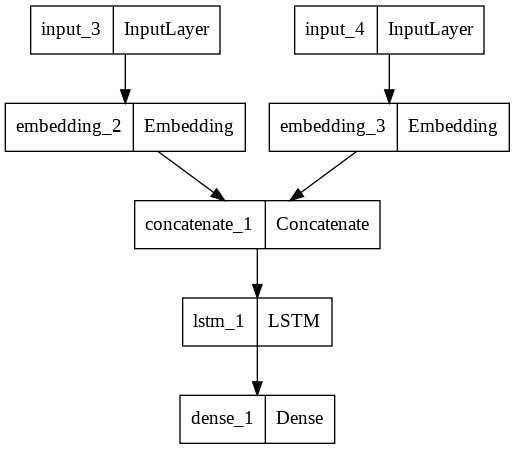

In [17]:
#plot model
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png')

In [28]:
#labels to categorical
from tensorflow.keras.utils import to_categorical
labels=train_df['label']
labels=to_categorical(labels)
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [44]:
model.fit([padded_headline,padded_articleBody],labels,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 31s 23ms/step - loss: 0.9366 - accuracy: 0.7932 - val_loss: 1.1125 - val_accuracy: 0.5709
Epoch 2/10
1250/1250 [==============================] - 27s 22ms/step - loss: 0.4976 - accuracy: 0.8430 - val_loss: 1.1376 - val_accuracy: 0.5718
Epoch 3/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.4269 - accuracy: 0.8589 - val_loss: 1.2124 - val_accuracy: 0.5677
Epoch 4/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3927 - accuracy: 0.8686 - val_loss: 1.3856 - val_accuracy: 0.5764
Epoch 5/10
1250/1250 [==============================] - 27s 21ms/step - loss: 0.3662 - accuracy: 0.8764 - val_loss: 1.5646 - val_accuracy: 0.5425
Epoch 6/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3400 - accuracy: 0.8852 - val_loss: 1.4840 - val_accuracy: 0.5514
Epoch 7/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3177 - accuracy: 0.8933 - val_loss: 1.5611 -

Dropout decrease val accuracy!
Now we are going to try word2vec

In [63]:
#tokenize list of sentences
from nltk.tokenize import word_tokenize
tokenized_corpus=[]
for i in corpus:
    tokenized_corpus.append(word_tokenize(i))
tokenized_corpus

[['Soldier',
  'shot',
  ',',
  'Parliament',
  'locked',
  'down',
  'after',
  'gunfire',
  'erupts',
  'at',
  'war',
  'memorial'],
 ['Tourist',
  'dubbed',
  '‘',
  'Spider',
  'Man',
  '’',
  'after',
  'spider',
  'burrows',
  'under',
  'skin',
  'for',
  'days'],
 ['Luke',
  'Somers',
  "'killed",
  'in',
  'failed',
  'rescue',
  'attempt',
  'in',
  'Yemen',
  "'"],
 ['BREAKING', ':', 'Soldier', 'shot', 'at', 'War', 'Memorial', 'in', 'Ottawa'],
 ['Giant',
  '8ft',
  '9in',
  'catfish',
  'weighing',
  '19',
  'stone',
  'caught',
  'in',
  'Italy',
  'is',
  'thought',
  'to',
  'be',
  'the',
  'biggest',
  'ever',
  'reeled',
  'in',
  'with',
  'a',
  'rod',
  'and',
  'line'],
 ['Enormous',
  '20-stone',
  'catfish',
  'caught',
  'with',
  'fishing',
  'rod',
  'in',
  'Italy',
  'after',
  '40-minute',
  'boat',
  'battle'],
 ['Italian',
  'catches',
  'huge',
  'wels',
  'catfish',
  ';',
  'is',
  'it',
  'a',
  'record',
  '?'],
 ['Not',
  'coming',
  'to',
  'a',
 

In [64]:
#word2vwc model
from gensim.models import Word2Vec
word2vwc_model=Word2Vec(tokenized_corpus,min_count=1,size=100,window=5,workers=4)

In [67]:
word2vwc_model.wv.most_similar('Isis')

[('ISIS', 0.6778564453125),
 ('IS', 0.6023392677307129),
 ('Islamic', 0.5060319900512695),
 ('group', 0.4789334535598755),
 ('al-Qaida', 0.4534173011779785),
 ('Islamist', 0.4428415894508362),
 ('militants', 0.4421060085296631),
 ('ISIL', 0.43903952836990356),
 ('State', 0.4347972869873047),
 ('extremists', 0.4237779378890991)]

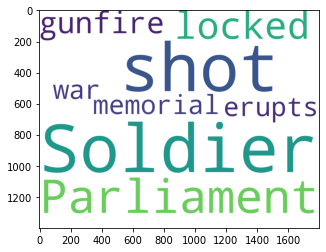

In [71]:
#draw words cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud=WordCloud(background_color='white',width=1800,height=1400).generate(corpus[0])
plt.imshow(wordcloud)

In [82]:
#one hot encode headline and article body
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer=Tokenizer(num_words=nb_words)
tokenizer.fit_on_texts(headline)
sequences=tokenizer.texts_to_sequences(headline)
#pad the sequences
padded_headline=pad_sequences(sequences,maxlen=max_seq_len)
#embedding matrix for headline
vocab_headline_len=len(tokenizer.word_index)+1
embedding_dim=100
headline_embedding_matrix=np.zeros((vocab_headline_len,embedding_dim))
for word,index in tokenizer.word_index.items():
    if word in word2vwc_model.wv.vocab:
        headline_embedding_matrix[index]=word2vwc_model.wv[word]
    
    
#article body
tokenizer.fit_on_texts(articleBody)
sequences=tokenizer.texts_to_sequences(articleBody)
padded_articleBody=pad_sequences(sequences,maxlen=max_seq_len)
#article body embedding matrix
vocab_body_len=len(tokenizer.word_index)+1
embedding_dim=100
articleBody_embedding_matrix=np.zeros((vocab_body_len,embedding_dim))
for word,index in tokenizer.word_index.items():
    if word in word2vwc_model.wv.vocab:
        articleBody_embedding_matrix[index]=word2vwc_model.wv[word]


In [84]:
#simple lstm model
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Input,Concatenate
from tensorflow.keras.models import Model
#import regularizers
from tensorflow.keras.regularizers import l2
headline_input=Input(shape=(max_seq_len,),dtype='int32' )
headline_embedding_layer=Embedding(vocab_headline_len,embedding_dim,input_length=max_seq_len,weights=[headline_embedding_matrix])(headline_input)
body_input=Input(shape=(max_seq_len,),dtype='int32')
body_embedding_layer=Embedding(vocab_body_len,embedding_dim,input_length=max_seq_len,weights=[articleBody_embedding_matrix])(body_input)
#concatenate two embedding layers
concatenated_embedding=Concatenate()([headline_embedding_layer,body_embedding_layer])
#lstm
lstm_layer=LSTM(64,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01))(concatenated_embedding)
#dense
dense_layer=Dense(4,activation='softmax')(lstm_layer)
model=Model(inputs=[headline_input,body_input],outputs=dense_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [85]:
model.fit([padded_headline,padded_articleBody],labels,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 30s 22ms/step - loss: 1.1016 - accuracy: 0.7839 - val_loss: 0.9968 - val_accuracy: 0.6356
Epoch 2/10
1250/1250 [==============================] - 28s 22ms/step - loss: 0.5556 - accuracy: 0.8348 - val_loss: 1.0466 - val_accuracy: 0.6425
Epoch 3/10
1250/1250 [==============================] - 28s 22ms/step - loss: 0.4652 - accuracy: 0.8655 - val_loss: 1.0899 - val_accuracy: 0.6212
Epoch 4/10
1250/1250 [==============================] - 27s 22ms/step - loss: 0.4120 - accuracy: 0.8850 - val_loss: 1.1574 - val_accuracy: 0.6321
Epoch 5/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3682 - accuracy: 0.8997 - val_loss: 1.1390 - val_accuracy: 0.6268
Epoch 6/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3386 - accuracy: 0.9106 - val_loss: 1.2104 - val_accuracy: 0.6443
Epoch 7/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3128 - accuracy: 0.9194 - val_loss: 1.2856 -